In [1]:
import sumie
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import skimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [75]:
class PixelMatch():
    
    def __init__(self, target, im, func=None, target_func=None):
        self.target = target.detach()
        self.im = im
        self.func = func
        self.target_func = target_func
        
    @property
    def objective(self):
        im_value = self.im.get_image()
        target_value = self.target
        if self.func:
            im_value = self.func(im_value)
        if self.target_func:
            target_value = self.target_func(target_value)
        return -1*torch.nn.MSELoss()(im_value, target_value)

class EdgeCost():
    
    def __init__(self, im):
        self.im = im
        
    @property
    def objective(self):
        mask = torch.ones(im().detach().shape).to('cuda')
        w = 20
        mask[:,:,w:-w,w:-1] = 0
        im_blur = torch.nn.functional.avg_pool2d(im().detach(), 5, stride=1, padding=2)
        difference = torch.sum(torch.mul(mask, im() - im_blur) ** 2)
        return -1*torch.mean(difference)


In [3]:
model = torchvision.models.googlenet(pretrained=True).eval()
sumie.utils.remove_inplace(model)
device = 'cuda'
model.to(device);

In [4]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Genkyuen02s3200.jpg/640px-Genkyuen02s3200.jpg'
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Nakamise_dori.jpg/640px-Nakamise_dori.jpg'
base_im = sumie.io.load_url(url)

torch.Size([1, 512, 30, 40])
n = torch.Size([30, 40])
torch.Size([1, 3, 16, 16])


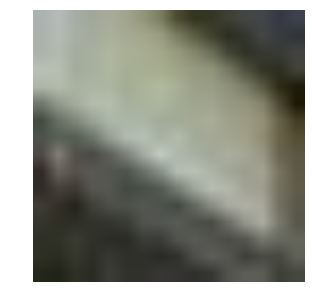

In [51]:
f_size = 64
imsize = 128
scale_fac = imsize//f_size
block = dict()
targets = dict()
#selected_module = list(model.modules())[-52]
selected_module = model.inception4c
#print(selected_module)
monitor = sumie.objectives.ModuleMonitor(selected_module)
n = 3

crop_sections = False

if crop_sections:
    for y in range(n):
        for x in range(n):
            block[(y, x)] = base_im[:, :, f_size*y:f_size*(y+1), f_size*x:f_size*(x+1)]
            model(sumie.utils.normalise(block[(y, x)].to(device)))
            targets[(y, x)] = monitor.values[:,:,1,1]
else:
    model(sumie.utils.normalise(base_im.to(device)))
    out_shape = monitor.values.shape
    print(out_shape)
    for y in range(out_shape[2]):
        for x in range(out_shape[3]):
            targets[(y, x)] = monitor.values[:,:,y,x]
    n = out_shape[2:]
    print(f'n = {n}')
    
block_size = [x//y for (x, y) in zip(base_im.shape[2:], n)]
for y in range(n[0]):
    for x in range(n[1]):
        block[(y, x)] = base_im[:, :, block_size[0]*y:block_size[0]*(y+1), block_size[1]*x:block_size[1]*(x+1)]
        
print(block[(0,0)].shape)
a = torch.nn.functional.interpolate(block[(6,6)], size=(256, 256), mode='bilinear')
sumie.vis.show(a)

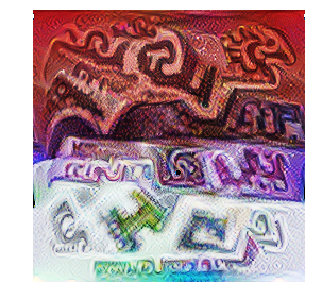

(0, 0)


In [95]:
outputs = dict()
n = (1,1)
imsize = 256

def change_scale(opt, i):
    if i == 128:
        opt.image.transforms[3].factor = 1

for y in range(n[0]):
    for x in range(n[1]):
        block_loc = (y, x)
        im = sumie.Image((imsize, imsize), param='fft', transforms=[
                    sumie.transforms.PositionJitter(16),
                    sumie.transforms.ScaleJitter(1.1),
                    sumie.transforms.RotationJitter(0.15),
                    sumie.transforms.Interpolate(0.5),
                    sumie.transforms.PositionJitter(8),
                    sumie.transforms.Normalise(),
              ], init=torch.nn.functional.interpolate(block[(y,x)], size=(imsize, imsize), mode='bilinear')
            )
        im.to(device)
        
        #match = PixelMatch(block[block_loc].to(device), im, 
        #                   func=torch.nn.AdaptiveAvgPool2d((f_size, f_size)))
                           #target_func=lambda x: torch.nn.functional.interpolate(x, scale_factor=4))
        conv = sumie.objectives.Direction(selected_module, targets[(y, x)][:,:,None,None])
        #edge = EdgeCost(im)
        #obj = sumie.objectives.Composite((edge, conv), weights=(1e-4, 1))
        opt = sumie.Optimiser(im, model, conv)
        opt.add_callback(change_scale)

        opt.run(iterations=256, progress=False, lr=0.05)
        outputs[block_loc] = im.get_image()
        sumie.vis.show(im.get_image())
        print((y, x))

In [7]:
final_im = torch.zeros(1, 3, n*imsize, n*imsize)
for y in range(n):
    for x in range(n):
        final_im[:, :, imsize*y:imsize*(y+1), imsize*x:imsize*(x+1)] = outputs[(y, x)]

TypeError: zeros(): argument 'size' must be tuple of ints, but found element of type tuple at pos 3

In [ ]:
sumie.vis.show(final_im)
sumie.io.save(final_im, 'montage.png')

RuntimeError: The size of tensor a (234) must match the size of tensor b (249) at non-singleton dimension 3

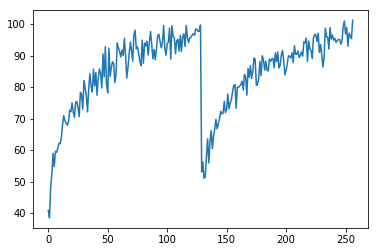

In [94]:
plt.plot([x.item() for x in opt.history])
for child in obj.children:
    print(child.objective)